In [1]:
from transformers import GPT2LMHeadModel

/Users/zanqiliang/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

Matplotlib is building the font cache; this may take a moment.


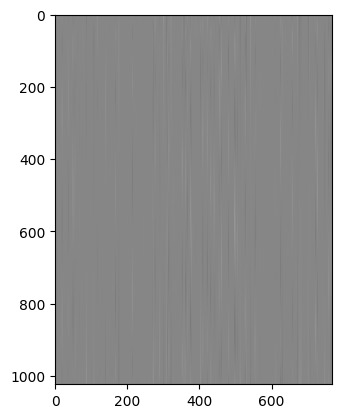

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

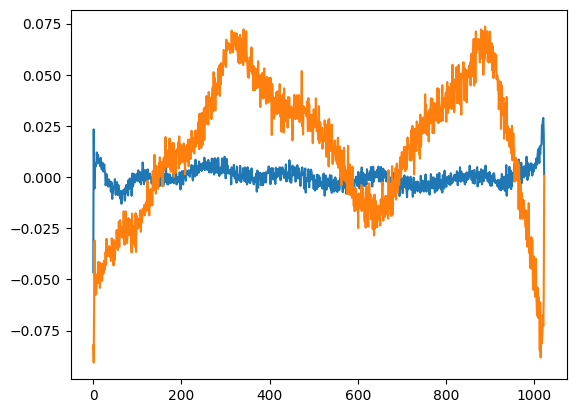

In [6]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 151])
# plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
# plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

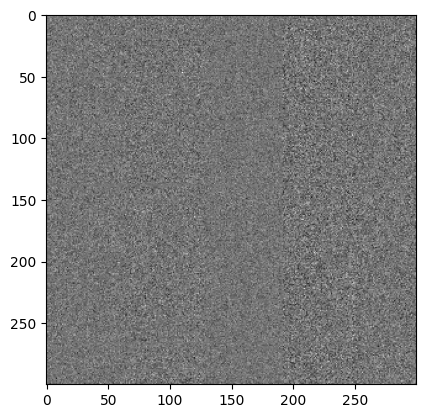

In [7]:
plt.imshow(sd_hf["transformer.h.0.attn.c_attn.weight"][:300, :300], cmap="gray")

In [8]:
from transformers import pipeline, set_seed
generator = pipeline("text-generation", model="gpt2")
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': "Hello, I'm a language model, and my project is based on the idea of a language model.\n\nI want to have a language that's both expressive and readable.\n\nLet's look at the following code:\n\nimport Data.ByteString\n\ndef get ( self ):\n\nself.data = Data.ByteString(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data.get())\n\nself.data.append(data"},
 {'generated_text': "Hello, I'm a language model, not a language model, and if I don't understand it, I won't learn to write it. So I was writing a system for programming in JavaScript and a s

In [11]:
import tiktoken
import torch
from torch.nn import functional as F

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

num_return_sequences = 5
max_length = 30

model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
model.to(device)

torch.manual_seed(42)

enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode("Hello, I'm a language model,")
# (8,)
tokens = torch.tensor(tokens, dtype=torch.long) 
# (5, 8)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device) # (B, T)

torch.manual_seed(42)
while x.size(1) < max_length:
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        logits = logits[:, -1, :] # (B, vocab_size)

        probs = F.softmax(logits, dim=-1)
        # topk_probs: (B, 50), topk_indices: (B, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # ix is the index in [0, 50), we want
        # xcol[i][j] = topk_indices[i][ix[i][j]]
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        x = torch.cat((x, xcol), dim=1)

for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)


> Hello, I'm a language model, which means I'm familiar with it, but I'm not fluent in that. Well, with that said,
> Hello, I'm a language model, and the syntax, to make use of it, is pretty good. So why do you have that and not
> Hello, I'm a language model, I'm doing this work in Python, and then I'm writing code for Haskell.

So we can
> Hello, I'm a language model, and you're making assumptions about my use of them. I'm not a natural language learner. I'm
> Hello, I'm a language model, well, I'm from Java and have to write a programming language for it. I have my own vocabulary because


In [12]:
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open("input.txt", 'r') as f:
    text = f.read()
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [13]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [2]:
import torch

buf = torch.tensor(tokens[: 24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

NameError: name 'tokens' is not defined

### Why residual scaling?

In [ ]:
# Standard deviation grow inside the residual stream.
x = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += torch.randn(768)
    # Replace with the following line to see the std remains 1.
    # x += n ** -0.5 * torch.randn(768)

# Zanqi: var(100x) = 100^2 * var(x) 
#   => std(100x) = sqrt(100^2 * var(x)) = 100 std(x). Why not 100?
# Answer: Because we are adding 100 independent random variables, not multiplying.
#   => std(x1 + ... + x100) = sqrt(100 * var(x)) = 10 = sqrt(n)
print(x.std().item())

0.9642618894577026
